# Margaret Doyle
## Final Project 
## ASTRO 250
## mddoyle@lbl.lgov

In [78]:
import h5py
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import utils
import matplotlib.pyplot as plt 
import random
from sklearn.model_selection import train_test_split
import random
from keras.models import Sequential
from keras.layers import Conv3D
import pandas as pd
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization
)
from tensorflow.keras.layers import Dense, Dropout, Flatten
import keras
from keras.models import Model
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import categorical_crossentropy
from keras import utils
import tensorflow as tf
import datetime, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow
from tensorflow.keras.layers import ( Conv1D,
    Conv2D, MaxPooling2D, MaxPooling1D,  Activation, BatchNormalization
)
import seaborn as sns


def check_unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    all_unique = []
    for x in unique_list:
        all_unique.append(x)
    return all_unique

# Load in training data, which I packaged into h5 format 

In [79]:
hf = h5py.File('train_data.h5', 'r')
images  = hf['image'][()]
labels = hf['label'][()]

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (15627,)
images shape: (15627, 400, 50)


# Examine classes 

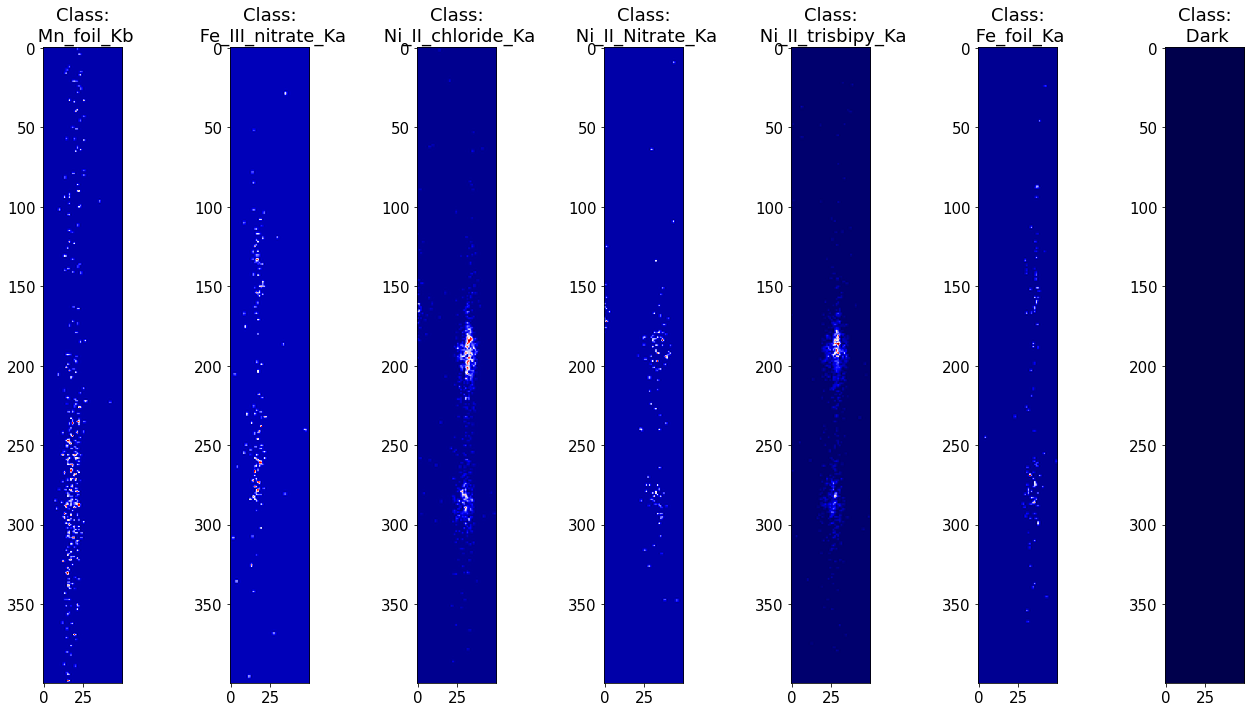

In [80]:
fig, axs = plt.subplots(1,len(check_unique(labels)), figsize=[18,10])
    
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

for i, ax in enumerate(axs.flatten()):
    random.seed(560) 
    
    subcat_labels = labels[labels ==check_unique(labels)[i]] #Focus on one subcategory at a time     
    subcat_images = images[labels ==check_unique(labels)[i]] 
    a =random.randint(0,(np.array(subcat_labels).shape[0]))
    
    ax.imshow(subcat_images[a],cmap = 'seismic')
    ax.set_title("Class:\n %s" %subcat_labels[0], fontsize=18)

plt.tight_layout()

# Get distribution of data

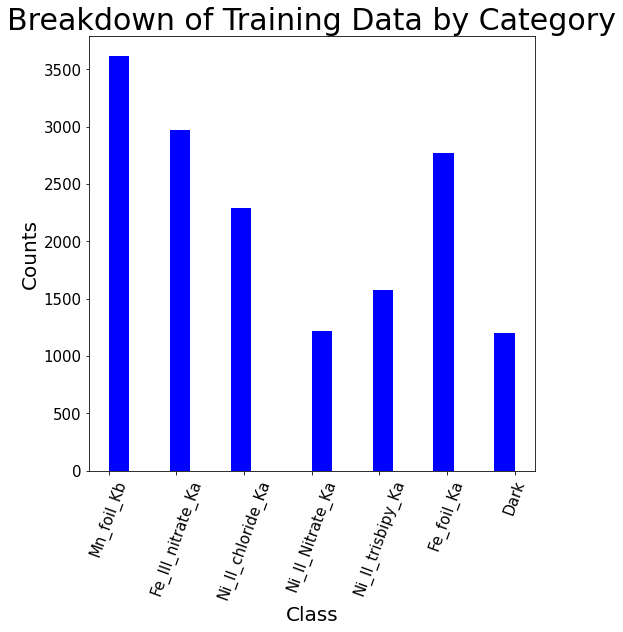

In [81]:
plt.figure(figsize=[8,8])

plt.hist(labels, bins=20,color='blue')
plt.xlabel('Class', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.title('Breakdown of Training Data by Category', fontsize=30)
plt.xticks(rotation = 70) 
plt.show()

# Convert labels so they can be used in training

In [82]:
list_of_labels = (check_unique(labels))
updated_labels  = ([0,0,0,0, 0, 0,0],) * len(labels)
updated_labels = np.array(updated_labels)
for x in range(0,len(labels)):
    for i in range(0,len(list_of_labels)): 

        if labels[x] == list_of_labels[i] :
            updated_labels[x][i] = 1 


# Split into training and testing data:

## Want to use 80% of data for training. 

## Use 10% of data for testing.  10% for validation.

In [83]:
from sklearn.model_selection import train_test_split
random_state = 40

x_train,x_test = train_test_split(np.arange(0,len(updated_labels)), train_size=0.80,  random_state = 0)

train_images = images[x_train]
train_labels = updated_labels[x_train]

test_images = images[x_test]
test_labels = updated_labels[x_test]

y_valid, y_test, x_valid, x_test = train_test_split(test_labels,test_images, test_size=0.5, random_state = 0)

print ("x_train shape: ", train_images.shape)
print ("y_train shape: ", train_labels.shape)
print('***')
print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)
print('***')
print ("x_valid shape:  ", x_valid.shape)
print ("y_valid shape:  ", y_valid.shape)

x_train shape:  (12501, 400, 50)
y_train shape:  (12501, 7)
***
x_test shape:   (1563, 400, 50)
y_test shape:   (1563, 7)
***
x_valid shape:   (1563, 400, 50)
y_valid shape:   (1563, 7)


In [84]:
input_lay = Input((400,50))

lay1 = Conv1D(filters=8, kernel_size=(3), activation='relu')(input_lay)
lay2 = Conv1D(filters=16, kernel_size=(3), activation='relu')(lay1)
pool_lay1 = MaxPooling1D(pool_size=(2))(lay2)
lay3 = Conv1D(filters=32, kernel_size=(3), activation='relu')(pool_lay1)
lay4 = Conv1D(filters=64, kernel_size=(3), activation='relu')(lay3)
pool_lay2 = MaxPooling1D(pool_size=(2))(lay4)

#Next, apply batch normalization 
pool_lay2 = BatchNormalization()(pool_lay2)
flatten_layer = Flatten()(pool_lay2)

#Adding dense layers 
dense_lay1 = Dense(64)(flatten_layer)
dense_lay2 = Dense(32)(dense_lay1)
output_layer= Dense(7,activation='softmax')(dense_lay2)


model = Model(inputs=input_lay, outputs=output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 50)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 398, 8)            1208      
                                                                 
 conv1d_5 (Conv1D)           (None, 396, 16)           400       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 198, 16)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 196, 32)           1568      
                                                                 
 conv1d_7 (Conv1D)           (None, 194, 64)           6208      
                                                           

In [85]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=2, min_lr=1e-5, verbose=1, cooldown=0)


model.fit(x=train_images, y=train_labels,batch_size=128, epochs=50, validation_split=0.2, validation_data = ( x_valid,  y_valid), callbacks =[earlystop, model_check, reduce_lr  ])
x_train.shape

Epoch 1/50
78/79 [============================>.] - ETA: 0s - loss: 0.1877 - accuracy: 0.9431
Epoch 1: val_accuracy improved from -inf to 0.87725, saving model to nn_results/ay250_nn_2022-05-11T16:55.h5
79/79 [==============================] - 11s 124ms/step - loss: 0.1874 - accuracy: 0.9432 - val_loss: 0.4498 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 2/50
78/79 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9930
Epoch 2: val_accuracy improved from 0.87725 to 0.98361, saving model to nn_results/ay250_nn_2022-05-11T16:55.h5
79/79 [==============================] - 7s 86ms/step - loss: 0.0260 - accuracy: 0.9930 - val_loss: 0.0522 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 3/50
78/79 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9973
Epoch 3: val_accuracy improved from 0.98361 to 0.99320, saving model to nn_results/ay250_nn_2022-05-11T16:55.h5
79/79 [==============================] - 6s 75ms/step - loss: 0.0084 - accuracy: 0.9973 - val_los

(12501,)

In [86]:
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
model = load_model(latest_model_file[0])

pred_y = model.predict(test_images)


# Examine a few examples to see how well model performed

Predicted: Ni_II_Nitrate_Ka
Real: Ni_II_Nitrate_Ka


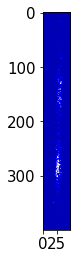

Predicted: Ni_II_chloride_Ka
Real: Ni_II_chloride_Ka


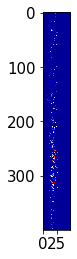

In [87]:
class_names = np.array(check_unique(labels))

ind = 0
plt.figure()
plt.imshow((x_test[ind]), cmap= 'seismic')
print("Predicted:", class_names[np.argmax(pred_y[ind])])
print("Real:" ,class_names[np.argmax(test_labels[ind])])
plt.show()

ind =140
plt.figure()
plt.imshow((x_test[ind]), cmap='seismic', interpolation='nearest')
print("Predicted:", class_names[np.argmax(pred_y[ind])])
print("Real:" ,class_names[np.argmax(test_labels[ind])])


# Plot confusion matrix to get a sense of overall performance 

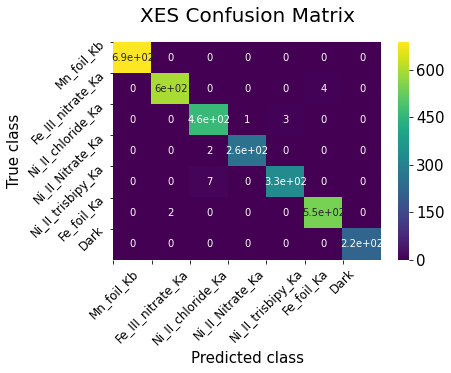

In [88]:
matrix = confusion_matrix(np.argmax(test_labels, axis=1) , np.argmax(pred_y, axis=1))
sns.heatmap(matrix, annot=True,cmap = "viridis")
plt.title('XES Confusion Matrix',fontsize=20,pad=20)
plt.xlabel('Predicted class',fontsize=15)
plt.ylabel('True class',fontsize=15)
plt.xticks(range(len(check_unique(labels))), check_unique(labels), fontsize=12)
plt.yticks(range(len(check_unique(labels))), check_unique(labels), fontsize=12)
plt.xticks(rotation = 45) 
plt.yticks(rotation = 45) 
plt.show()

# Accuracy was *slightly* higher than val_accuracy. Want to avoid overfitting...


# Next step will be to augment images, thus increasing number of examples used to train model. I will add random noise to each image, and also flip it. 

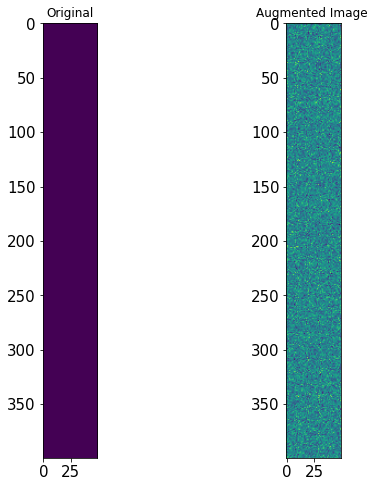

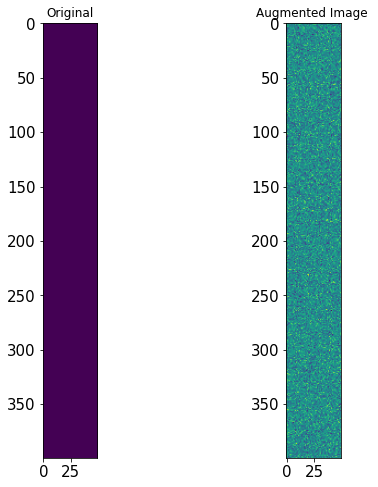

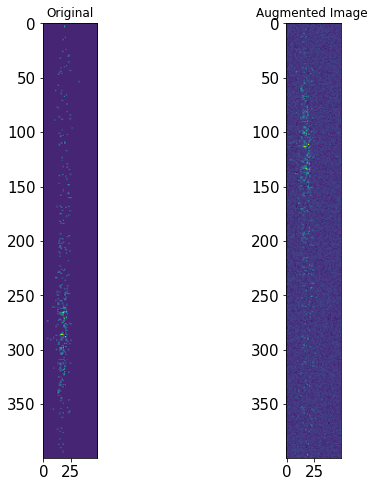

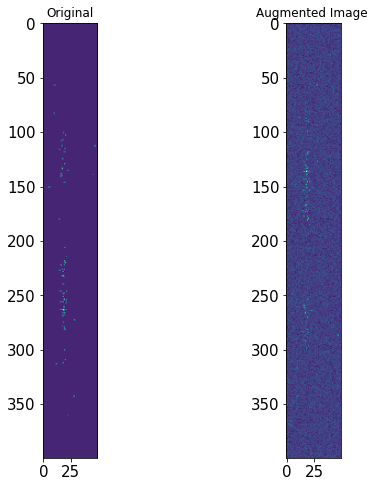

<class 'list'> <class 'numpy.ndarray'>


In [89]:
def augment_me(img):
    noise = np.random.normal(100,10, img.shape)
    return np.flipud(img + noise)


augmented_images = []
i=0
for x in train_images:
    i=i+1
    if i < 5:
        fig,ax = plt.subplots(1,2, figsize=[8,8])
        ax[0].imshow(x)
        ax[0].set_title('Original')
        ax[1].imshow(augment_me(x))
        ax[1].set_title('Augmented Image ')
        plt.show()
    augmented_images.append(augment_me(x))

print(type(augmented_images), type(train_images))

In [90]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.fit(x=np.array(augmented_images), y=train_labels,batch_size=128, epochs=50, validation_split=0.2, validation_data = ( x_valid,  y_valid), callbacks =[earlystop, model_check, reduce_lr  ])


Epoch 1/50
78/79 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.9142
Epoch 1: val_accuracy did not improve from 0.99320
79/79 [==============================] - 8s 84ms/step - loss: 0.3420 - accuracy: 0.9143 - val_loss: 55.2816 - val_accuracy: 0.2747 - lr: 0.0010
Epoch 2/50
78/79 [============================>.] - ETA: 0s - loss: 0.0393 - accuracy: 0.9885
Epoch 2: val_accuracy did not improve from 0.99320
79/79 [==============================] - 6s 78ms/step - loss: 0.0393 - accuracy: 0.9884 - val_loss: 19.2837 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 3/50
78/79 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.9899
Epoch 3: val_accuracy did not improve from 0.99320
79/79 [==============================] - 7s 93ms/step - loss: 0.0321 - accuracy: 0.9899 - val_loss: 20.9561 - val_accuracy: 0.6074 - lr: 0.0010
Epoch 4/50
78/79 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9940
Epoch 4: val_accuracy did not improve f

In [91]:
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
model = load_model(latest_model_file[0])

pred_y = model.predict(test_images)


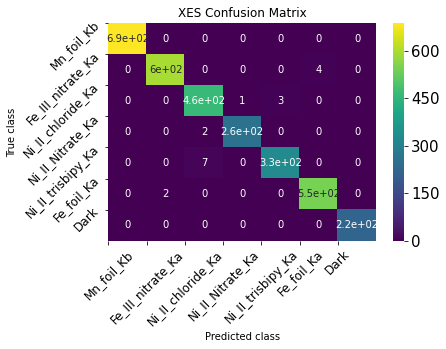

In [92]:
matrix = confusion_matrix(np.argmax(test_labels, axis=1) , np.argmax(pred_y, axis=1))
sns.heatmap(matrix, annot=True, cmap =  "viridis")
plt.title('XES Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(range(len(check_unique(labels))), check_unique(labels), fontsize=12)
plt.yticks(range(len(check_unique(labels))), check_unique(labels), fontsize=12)
plt.xticks(rotation = 45) 
plt.yticks(rotation = 45) 
plt.show()

# Beginning to integrate results into web app with flask

In [93]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
import pickle
pickle.dump(model, open('model.pkl','wb'))

INFO:tensorflow:Assets written to: ram://884b4ae3-f092-4a75-9c3b-b9941a45fa8d/assets


# While I'm at it, I will save out a test image 

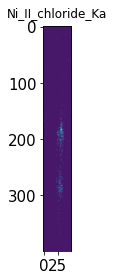

(12501, 400, 50)
(12501, 7)


In [94]:
i = 1000
plt.figure()
plt.imshow(train_images[i])
plt.title('%s' %check_unique(labels)[np.argmax(train_labels[i])], pad=10)
plt.tight_layout()
plt.show()

np.save('test_%s.npy' %check_unique(labels)[np.argmax(train_labels[i])], train_images[i:i+1])
print(np.shape(train_images))
print(np.shape(train_labels))

In [95]:
a = np.load('test_%s.npy' %check_unique(labels)[np.argmax(train_labels[i])])